# <center> BSE Test </center>
<center> CM </center>

# Initial Setup 

In [1]:
# Initial Setup:

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# Helpful functions

In [2]:
# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')  

# Set up

In [3]:
start_time = 0
end_time = 60 * 10

In [4]:
verbose = False
tdump=open('avg_balance.csv','w')
trial_id = 'TRIAL_2'
dump_all = True

# Offset functions 

In [5]:
def schedule_offsetfn(t):
    pi2 = math.pi * 2
    c = math.pi * 3000
    wavelength = t / c
    gradient = 100 * t / (c / pi2)
    amplitude = 100 * t / (c / pi2)
    offset = gradient + amplitude * math.sin(wavelength * t)
    return int(round(offset, 0))

In [6]:
def offset_t(t):
    return int(round(t,0))

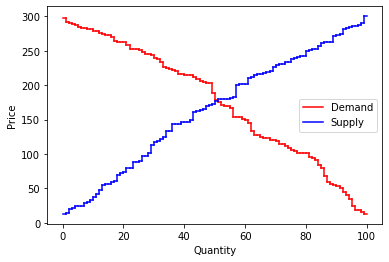

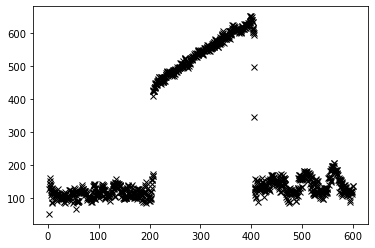

In [9]:
range1 = (10,190,schedule_offsetfn)
range2 = (200,300,offset_t)
shock_time_1 = int(end_time / 3)
shock_time_2 = int(end_time*(2/3))

supply_schedule = [ {'from':0, 'to':shock_time_1, 'ranges':[range1], 'stepmode':'fixed'},
              {'from':shock_time_1, 'to':shock_time_2, 'ranges':[range2], 'stepmode':'fixed'},
              {'from':shock_time_2, 'to':end_time, 'ranges':[range1], 'stepmode':'fixed'}
            ]
demand_schedule = supply_schedule

sup_range = [(range1),(range2)]
dem_range = sup_range
sup_dem(100, sup_range, 100, dem_range, 'random')

sellers_spec = [('ZIP', 10), ('ZIC', 10), ('SHVR', 10), ('GVWY', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'TRIAL_2' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    prices_fname = trial_id + '_transactions.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');